# CS421: Introduction to Machine Learning
## Project: Predicting Credit Card Customer Churn
### Performance Evaluation
---

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from xgboost import plot_tree

In [17]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")

y_train = df_train[["attrition_flag"]]
x_train = df_train.drop("attrition_flag", axis=1)

y_test = df_test[["attrition_flag"]]
x_test = df_test.drop("attrition_flag", axis=1)

x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8101 entries, 0 to 8100
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_age              8101 non-null   int64  
 1   gender                    8101 non-null   int64  
 2   dependent_count           8101 non-null   int64  
 3   total_relationship_count  8101 non-null   int64  
 4   months_inactive_12_mon    8101 non-null   int64  
 5   contacts_count_12_mon     8101 non-null   int64  
 6   credit_limit              8101 non-null   float64
 7   total_revolving_bal       8101 non-null   int64  
 8   total_amt_change_q4_q1    8101 non-null   float64
 9   total_trans_count         8101 non-null   int64  
 10  total_count_change_q4_q1  8101 non-null   float64
 11  avg_utilization_ratio     8101 non-null   float64
dtypes: float64(4), int64(8)
memory usage: 759.6 KB


In [4]:
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

def build_model(model):
    global x_train
    global y_train
    
    smote_sampler = SMOTE(random_state=2021)

    scale_features = x_train.columns

    scaler = ColumnTransformer(transformers=[ ('scaler', MinMaxScaler(), scale_features) ])

    pipeline = Pipeline(steps = [['scaler', scaler],
                                 ['smote', smote_sampler],
                                 ['classifier', model]])

    pipeline.fit(x_train, y_train.values.ravel() )

    y_pred = pipeline.predict(x_test)
    
    return pipeline, y_pred

In [5]:
from sklearn.metrics import recall_score, fbeta_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix

def display_metrics(model_name, y_pred):
    print(f"-----------------------PERFORMANCE EVALUATION: {model_name}--------------------  ")
    print(f"Recall: {recall_score(y_test, y_pred)} ")
    print(f"Fbeta2: {fbeta_score(y_test, y_pred, beta=2)} ")
    print(f"AUC Score: {roc_auc_score(y_test, y_pred)} ")
    
    cm = confusion_matrix(y_test, y_pred)
    labels = ['Existing Customer', 'Attrited Customer']

    diagram = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    diagram.plot(cmap=plt.cm.Blues)
    plt.show()

# 1. Logistic Regression
---

-----------------------PERFORMANCE EVALUATION: Logistic Regression--------------------  
Recall: 0.7169230769230769 
Fbeta2: 0.6328082563824009 
AUC Score: 0.76792655903767 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


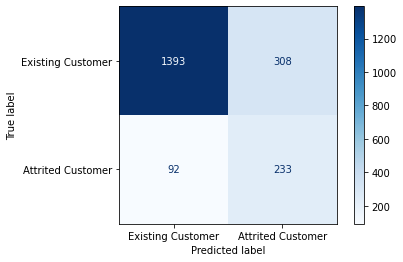

In [5]:
lr_clf = LogisticRegression(
    C=0.5,
    fit_intercept=True,
    max_iter=10,
    multi_class='auto',
    penalty='l2',
    solver='sag',
    random_state=2021
)

lr_pipeline, lr_ypred = build_model(lr_clf)
display_metrics('Logistic Regression', lr_ypred)

# 2. Support Vector Classifier (SVC)
---

-----------------------PERFORMANCE EVALUATION: Support Vector Classifier--------------------  
Recall: 0.8215384615384616 
Fbeta2: 0.7512661789532921 
AUC Score: 0.8490408357075024 


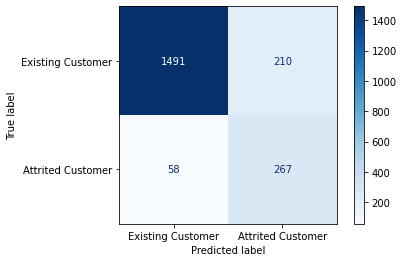

In [6]:
svc_clf = SVC(C=1000, gamma=0.1, kernel='rbf', random_state = 2021, probability=True)

svc_pipeline, svc_ypred = build_model(svc_clf)
display_metrics('Support Vector Classifier', svc_ypred)

# 3. RandomForest
---

-----------------------PERFORMANCE EVALUATION: Random Forest--------------------  
Recall: 0.8584615384615385 
Fbeta2: 0.8323389021479715 
AUC Score: 0.9007181296070186 


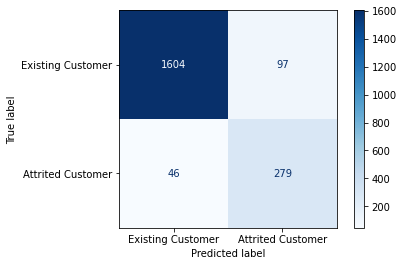

In [7]:
rf_clf = RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=8,
                                    min_samples_split=2, n_estimators=125,
                                    random_state=2021)

rf_pipeline, rf_ypred = build_model(rf_clf)
display_metrics('Random Forest', rf_ypred)

# 4. XGBoost
---

-----------------------PERFORMANCE EVALUATION: XGBoost--------------------  
Recall: 0.8738461538461538 
Fbeta2: 0.8647990255785628 
AUC Score: 0.9198742820965042 


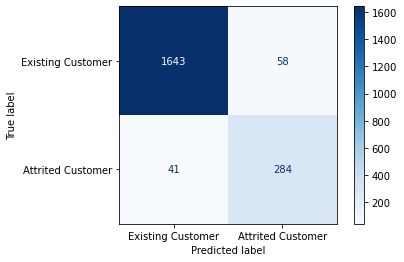

In [7]:
xgb_clf = XGBClassifier(learning_rate=0.25,
                    max_depth=3,
                    gamma=1,
                    subsample=0.9,
                    eval_metric="logloss", 
                    use_label_encoder=False, 
                    random_state=2021)

xgb_pipeline, xgb_ypred = build_model(xgb_clf)
display_metrics("XGBoost", xgb_ypred)

# 5. ROC Curve

In [10]:
from sklearn.metrics import roc_curve

proba_dict = {
    "Logistic Regression": lr_clf.predict_proba(x_test)[:, 1],
    "SVC": svc_clf.predict_proba(x_test)[:, 1],
    "RandomForest": rf_clf.predict_proba(x_test)[:, 1],
    "XGBoost": xgb_clf.predict_proba(x_test)[:, 1]
}

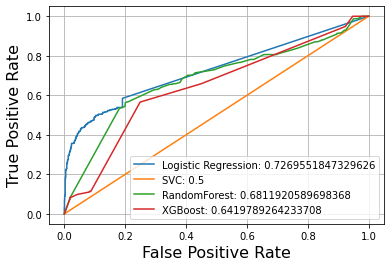

<Figure size 1080x864 with 0 Axes>

In [11]:
for model, proba in proba_dict.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f"{model}: {auc}")
    
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend(loc='best')
plt.grid(True)
plt.figure(figsize=(15, 12))
plt.show()

# 6. XGBoost Feature Importance

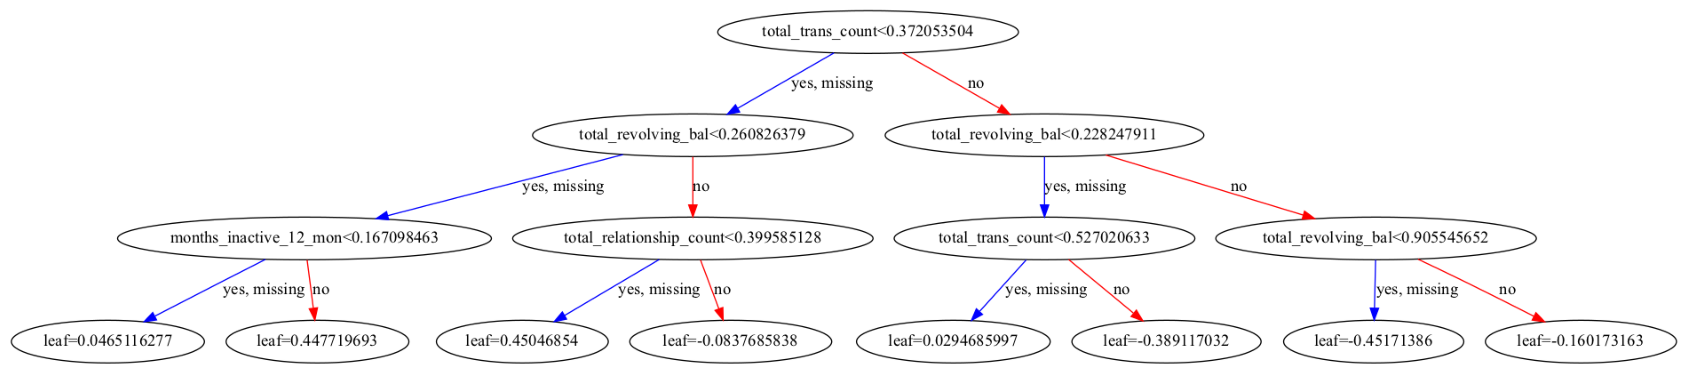

In [18]:
fig, ax = plt.subplots(figsize=(30, 30))
# xgb_clf.get_booster().feature_names = x_train.columns
plot_tree(xgb_clf, ax=ax, fmap="column_names.txt", dpi=600)
plt.show()

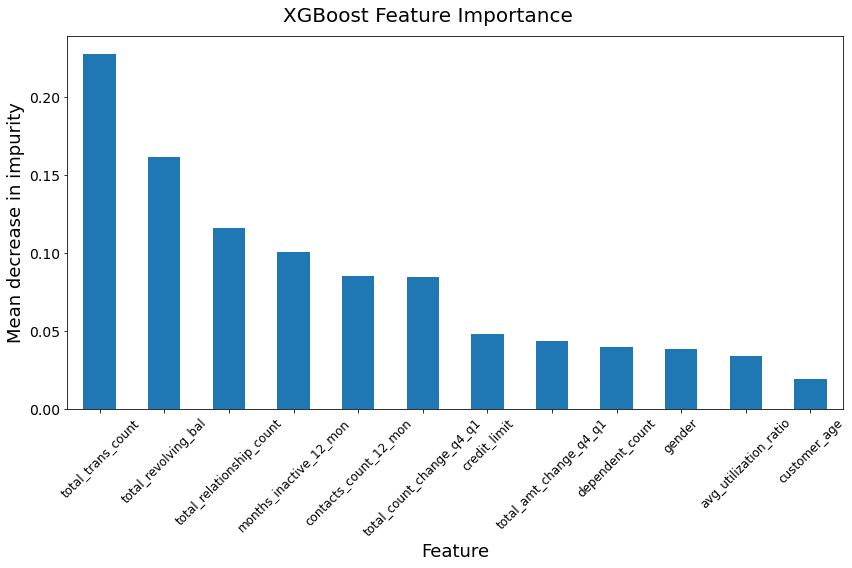

In [16]:
xgb_importances = pd.Series(xgb_pipeline[-1].feature_importances_, index=x_test.columns)
xgb_importances.sort_values(ascending=False, inplace=True)


fig, ax = plt.subplots( figsize=(12, 8))
xgb_importances.plot.bar(ax=ax)
fig.suptitle('XGBoost Feature Importance', fontsize=20)
plt.xlabel('Feature', fontsize=18)
plt.ylabel('Mean decrease in impurity', fontsize=18)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=14)
fig.tight_layout()

# 7. Random Forest Feature Importance

In [20]:
rf_importance = pd.DataFrame( rf_pipeline[2].feature_importances_, x_test.columns)
rf_importance.sort_values(by=[0], ascending=False)

,0
total_trans_count,0.306895
total_revolving_bal,0.159891
total_count_change_q4_q1,0.129322
months_inactive_12_mon,0.082027
contacts_count_12_mon,0.079455
avg_utilization_ratio,0.072977
total_relationship_count,0.063832
total_amt_change_q4_q1,0.039712
credit_limit,0.028307
customer_age,0.020419
